In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit.synthesis import LieTrotter, SuzukiTrotter, MatrixExponential
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE

In [32]:
def get_hamiltonian(nq, J):
    op_list = [("ZZ", [i, i + 1], J) for i in range(nq - 1)]
    op_list.append(("ZZ", [nq - 1, 0], J))
    op_list += [("X", [i], J) for i in range(nq)]
    return SparsePauliOp.from_sparse_list(op_list, num_qubits=nq).simplify()


def ansatz_hea(nqubits, depth, params):
    circuit = QuantumCircuit(nqubits)
    t = 0
    for _ in range(depth):
        for i in range(nqubits):
            circuit.ry(params[t], i)
            t += 1
        circuit.barrier()
        for i in range(nqubits - 1):
            circuit.cx(i, i + 1)
    return circuit

def select_sim(error_rate):
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
    error1 = depolarizing_error(error_rate * 10, 2)
    noise_model.add_all_qubit_quantum_error(error1, "cx")
    sim_d = AerSimulator(noise_model=noise_model)
    if error_rate == 0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
    return simulator
import numpy as np
from qiskit import QuantumCircuit

def ansatz_hea_partial(nqubits, depth, trainable_params):
    circuit = QuantumCircuit(nqubits)
    
    # 固定前 depth - 1 层参数（随机生成）
    for _ in range(depth - 1):
        for i in range(nqubits):
            theta = np.random.uniform(0, 2 * np.pi)  # 固定值，每次调用不同
            circuit.ry(theta, i)
        circuit.barrier()
        for i in range(nqubits - 1):
            circuit.cx(i, i + 1)

    # 最后一层用可训练参数
    for i in range(nqubits):
        circuit.ry(trainable_params[i], i)
    circuit.barrier()
    for i in range(nqubits - 1):
        circuit.cx(i, i + 1)

    return circuit

def cost_function(params, nqubits, depth, error_rate):
    J = 1/np.sqrt(2)
    hamiltonian =  SparsePauliOp.from_list([('ZZIII', 1.0)])
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

def vqe(nqubits, depth, error_rate):
    #vqe_nparams = depth * 2 * nqubits  ## hva
    vqe_nparams = depth * nqubits ## hea
    #vqe_nparams = nqubits ##hea_partial
    vqe_params = np.random.random(vqe_nparams)
    result_intermediate = []
    def callback(intermediate_result):
        result_intermediate.append(intermediate_result.fun)
    estimate_val = sp.optimize.minimize(cost_function, vqe_params, args=(nqubits, depth, error_rate), method="Powell",
                                        tol=1e-5,
                                        options={'disp': True}, callback=callback)
    print(estimate_val)
    return result_intermediate

def plot_data3(
    filename, nstep, intermediate_values):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    step = list(range(nstep[0]))
    step1 = list(range(nstep[1]))
    step2 = list(range(nstep[2]))
    step3 = list(range(nstep[3]))
    colors = ["darkmagenta", "limegreen", "k","r"]
    markers = ["*", "x", "v", "1"]
    ax1.plot(
        step,
        intermediate_values[0],
        label="Expect error 0",
        #marker=markers[0],
        c=colors[0],
        ls="-",
        lw=0.8,
    )
    ax1.plot(
        step1,
        intermediate_values[1],
        label="Expect error 1e-4",
        #marker=markers[1],
        c=colors[1],
        ls="-",
        lw=0.8,
    )
    ax1.plot(
        step2,
        intermediate_values[2],
        label="Expect error 1e-3",
        #marker=markers[2],
        c=colors[2],
        ls="-",
        lw=0.8,
    )
    ax1.plot(
        step3,
        intermediate_values[3],
        label="Expect error 1e-2",
        #marker=markers[3],
        c=colors[3],
        ls="-",
        lw=0.8,
    )
    ax1.axhline(
        y=np.min(np.concatenate(intermediate_values)),
        color="r",
        linestyle="--",
        label="Minimum expectation",
    )
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Expectation", color=colors[0])
    ax1.tick_params(axis="y", labelcolor=colors[0])

    handles1, labels1 = ax1.get_legend_handles_labels()

    all_handles = handles1
    all_labels = labels1

    legend = fig.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(0, 0, 1, 1),
        loc="upper right",
        # ncol=3,
        borderaxespad=0,
        fontsize=8,
        bbox_transform=ax1.transAxes
    )

    #ax1.set_title("Only VQE for expectation over Steps")

    fig.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.show()



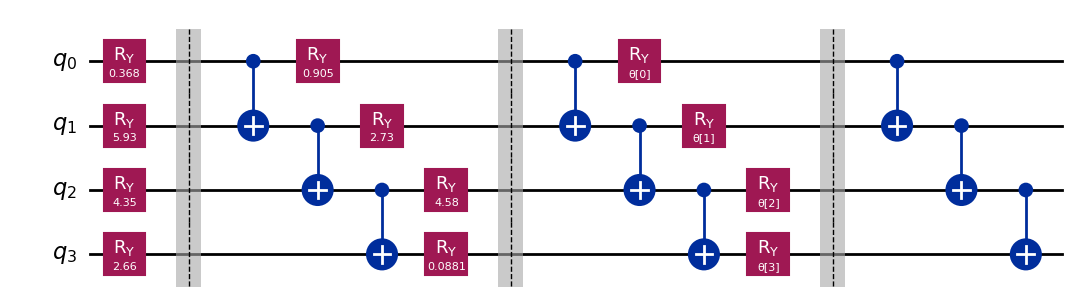

In [19]:
ansatz_hea_partial(4, 3, ParameterVector('θ', 4)).draw('mpl')

Optimization terminated successfully.
         Current function value: -0.999984
         Iterations: 7
         Function evaluations: 2330
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.9999841140669871
       x: [ 4.273e+00 -1.280e+00 ... -1.639e+00  8.652e-01]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 2.938e-02 -5.927e-02 ...  1.085e-10 -6.027e-04]]
    nfev: 2330


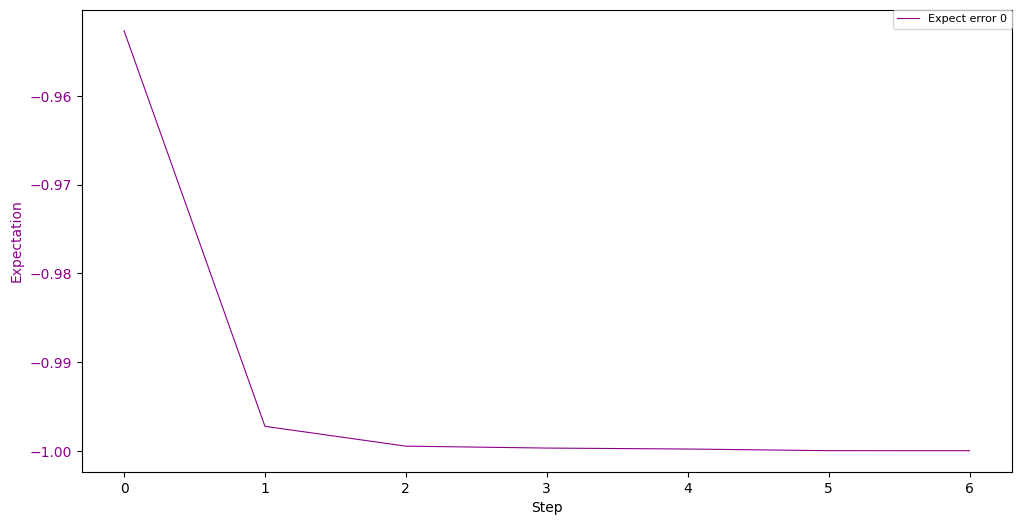

In [38]:
nqubits = 5
error_rate = 0
depth = 5
##pure VQE
#cut_off = 30
result = vqe(nqubits, depth, error_rate)
#result = result[:cut_off]
#result1 = vqe(nqubits, depth, error_rate1)
#result1 = result1[:cut_off]
#result2 = vqe(nqubits, depth, error_rate2)
#result2 = result2[:cut_off]
#result3 = vqe(nqubits, depth, error_rate3)
#result3 = result3[:cut_off]
fig, ax1 = plt.subplots(figsize=(12, 6))
colors = ["darkmagenta", "limegreen", "k","r"]
markers = ["*", "x", "v", "1"]
ax1.plot(
        range(len(result)),
        result,
        label="Expect error 0",
        #marker=markers[0],
        c=colors[0],
        ls="-",
        lw=0.8,
    )

ax1.set_xlabel("Step")
ax1.set_ylabel("Expectation", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

handles1, labels1 = ax1.get_legend_handles_labels()

all_handles = handles1
all_labels = labels1

legend = fig.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(0, 0, 1, 1),
        loc="upper right",
        # ncol=3,
        borderaxespad=0,
        fontsize=8,
        bbox_transform=ax1.transAxes
    )

    #ax1.set_title("Only VQE for expectation over Steps")

plt.show()

Optimization terminated successfully.
         Current function value: -0.886223
         Iterations: 73
         Function evaluations: 168390
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.8862226330894332
       x: [ 4.580e+00 -2.154e-01 ...  3.324e-01  3.582e-01]
     nit: 73
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 2.422e-02 -3.262e-02 ... -6.018e-06  8.271e-03]]
    nfev: 168390


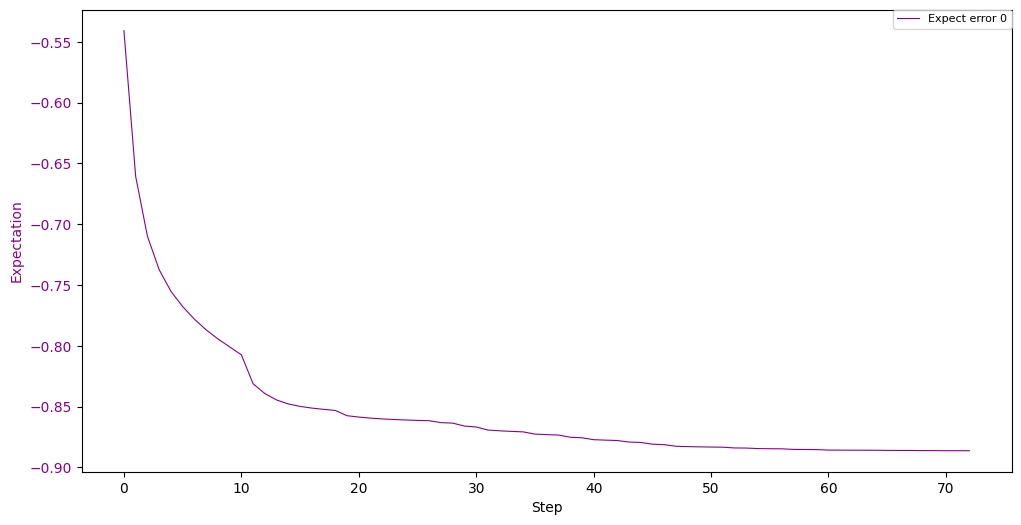

In [39]:
def cost_function(params, nqubits, depth, error_rate):
    J = 1/np.sqrt(2)
    hamiltonian =  SparsePauliOp.from_list([('ZZIIIIIIII', 1.0)])
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

def vqe(nqubits, depth, error_rate):
    #vqe_nparams = depth * 2 * nqubits  ## hva
    vqe_nparams = depth * nqubits ## hea
    #vqe_nparams = nqubits ##hea_partial
    vqe_params = np.random.random(vqe_nparams)
    result_intermediate = []
    def callback(intermediate_result):
        result_intermediate.append(intermediate_result.fun)
    estimate_val = sp.optimize.minimize(cost_function, vqe_params, args=(nqubits, depth, error_rate), method="Powell",
                                        tol=1e-5,
                                        options={'disp': True}, callback=callback)
    print(estimate_val)
    return result_intermediate

nqubits = 10
error_rate = 0
depth = 20
##pure VQE
#cut_off = 30
result = vqe(nqubits, depth, error_rate)
#result = result[:cut_off]
#result1 = vqe(nqubits, depth, error_rate1)
#result1 = result1[:cut_off]
#result2 = vqe(nqubits, depth, error_rate2)
#result2 = result2[:cut_off]
#result3 = vqe(nqubits, depth, error_rate3)
#result3 = result3[:cut_off]
fig, ax1 = plt.subplots(figsize=(12, 6))
colors = ["darkmagenta", "limegreen", "k","r"]
markers = ["*", "x", "v", "1"]
ax1.plot(
        range(len(result)),
        result,
        label="Expect error 0",
        #marker=markers[0],
        c=colors[0],
        ls="-",
        lw=0.8,
    )

ax1.set_xlabel("Step")
ax1.set_ylabel("Expectation", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

handles1, labels1 = ax1.get_legend_handles_labels()

all_handles = handles1
all_labels = labels1

legend = fig.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(0, 0, 1, 1),
        loc="upper right",
        # ncol=3,
        borderaxespad=0,
        fontsize=8,
        bbox_transform=ax1.transAxes
    )

    #ax1.set_title("Only VQE for expectation over Steps")

plt.show()

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 2
         Function evaluations: 1082
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -1.000000000000002
       x: [ 3.142e+00  4.504e-11 ...  5.117e-01  1.746e-02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 1082


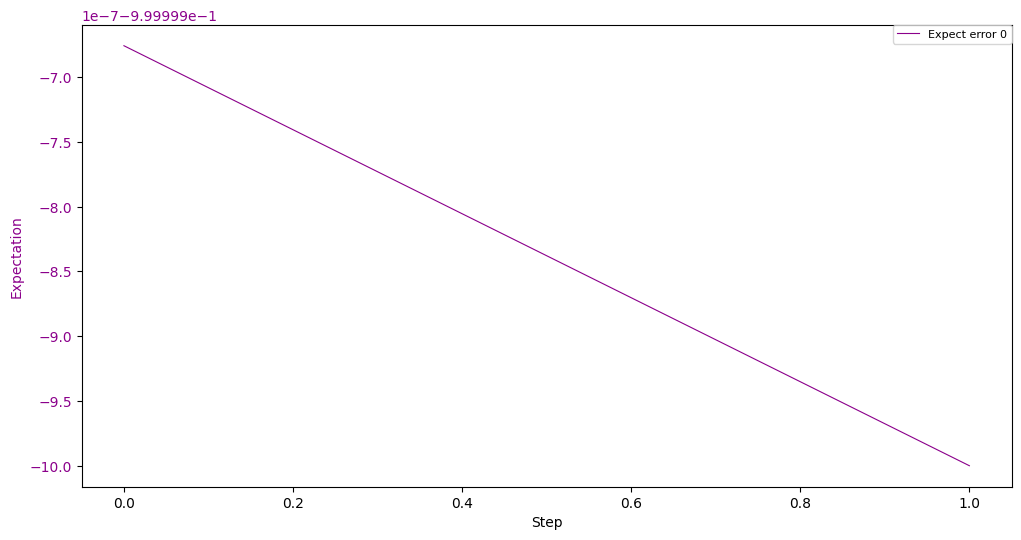

In [40]:
def cost_function(params, nqubits, depth, error_rate):
    J = 1/np.sqrt(2)
    hamiltonian =  SparsePauliOp.from_list([('ZZIIIIIIII', 1.0)])
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

def vqe(nqubits, depth, error_rate):
    #vqe_nparams = depth * 2 * nqubits  ## hva
    vqe_nparams = depth * nqubits ## hea
    #vqe_nparams = nqubits ##hea_partial
    vqe_params = np.random.random(vqe_nparams)
    result_intermediate = []
    def callback(intermediate_result):
        result_intermediate.append(intermediate_result.fun)
    estimate_val = sp.optimize.minimize(cost_function, vqe_params, args=(nqubits, depth, error_rate), method="Powell",
                                        tol=1e-5,
                                        options={'disp': True}, callback=callback)
    print(estimate_val)
    return result_intermediate

nqubits = 10
error_rate = 0
depth = 2
##pure VQE
#cut_off = 30
result = vqe(nqubits, depth, error_rate)
#result = result[:cut_off]
#result1 = vqe(nqubits, depth, error_rate1)
#result1 = result1[:cut_off]
#result2 = vqe(nqubits, depth, error_rate2)
#result2 = result2[:cut_off]
#result3 = vqe(nqubits, depth, error_rate3)
#result3 = result3[:cut_off]
fig, ax1 = plt.subplots(figsize=(12, 6))
colors = ["darkmagenta", "limegreen", "k","r"]
markers = ["*", "x", "v", "1"]
ax1.plot(
        range(len(result)),
        result,
        label="Expect error 0",
        #marker=markers[0],
        c=colors[0],
        ls="-",
        lw=0.8,
    )

ax1.set_xlabel("Step")
ax1.set_ylabel("Expectation", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

handles1, labels1 = ax1.get_legend_handles_labels()

all_handles = handles1
all_labels = labels1

legend = fig.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(0, 0, 1, 1),
        loc="upper right",
        # ncol=3,
        borderaxespad=0,
        fontsize=8,
        bbox_transform=ax1.transAxes
    )

    #ax1.set_title("Only VQE for expectation over Steps")

plt.show()

Optimization terminated successfully.
         Current function value: -3.681675
         Iterations: 10
         Function evaluations: 835
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -3.6816753266148106
       x: [ 3.142e+00 -4.543e-01 -6.050e-01  1.005e+00 -1.571e+00
            1.040e+00 -1.340e+00  1.901e+00]
     nit: 10
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [-8.147e-04 -4.919e-02 ... -8.698e-02  4.402e-02]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 1.875e-04  3.354e-03 ... -2.384e-03  3.569e-03]]
    nfev: 835


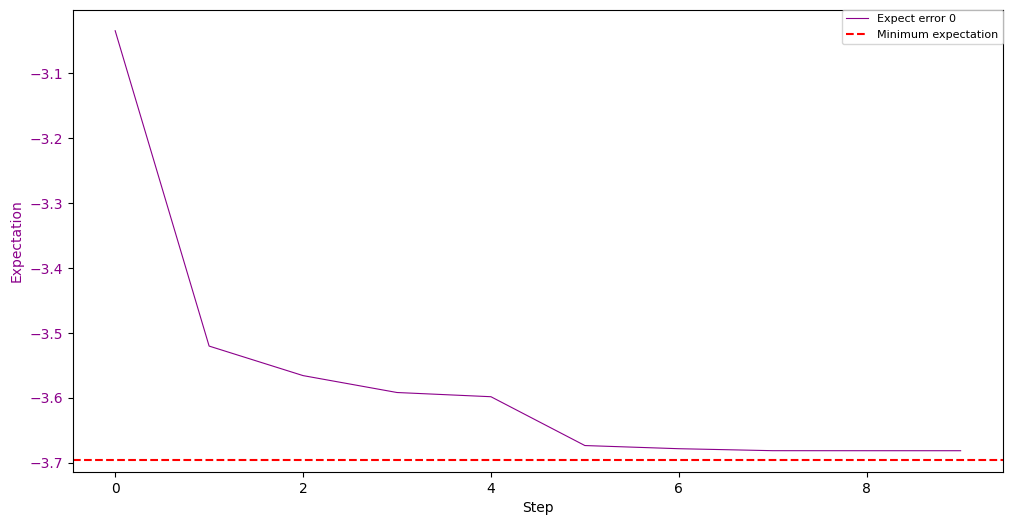

In [47]:
def cost_function(params, nqubits, depth, error_rate):
    J = 1/np.sqrt(2)
    hamiltonian =  get_hamiltonian(nqubits,J)
    circuit =  ansatz_hea(nqubits, depth,params)
    circuit = circuit.decompose()
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    #circuit.save_statevector()
    if error_rate == 0:
        estimator = EstimatorV2()
        #print('error rate is 0')
    else:
        #print('error rate is ' + str(error_rate))
        estimator = EstimatorV2(options=dict(backend_options=dict(noise_model=noise_model)))
        #circuit = transpile(circuit, sim_d)
        #noise_result = sim_d.run(circ_noise, shots=1).result()
    result =estimator.run([(circuit, hamiltonian)]).result()
    expectation=result[0].data.evs
    return expectation.real

def vqe(nqubits, depth, error_rate):
    #vqe_nparams = depth * 2 * nqubits  ## hva
    vqe_nparams = depth * nqubits ## hea
    #vqe_nparams = nqubits ##hea_partial
    vqe_params = np.random.random(vqe_nparams)
    result_intermediate = []
    def callback(intermediate_result):
        result_intermediate.append(intermediate_result.fun)
    estimate_val = sp.optimize.minimize(cost_function, vqe_params, args=(nqubits, depth, error_rate), method="Powell",
                                        tol=1e-5,
                                        options={'disp': True}, callback=callback)
    print(estimate_val)
    return result_intermediate

nqubits = 4
error_rate = 0
depth = 2
##pure VQE
#cut_off = 30
result = vqe(nqubits, depth, error_rate)
#result = result[:cut_off]
#result1 = vqe(nqubits, depth, error_rate1)
#result1 = result1[:cut_off]
#result2 = vqe(nqubits, depth, error_rate2)
#result2 = result2[:cut_off]
#result3 = vqe(nqubits, depth, error_rate3)
#result3 = result3[:cut_off]
fig, ax1 = plt.subplots(figsize=(12, 6))
colors = ["darkmagenta", "limegreen", "k","r"]
markers = ["*", "x", "v", "1"]
ax1.plot(
        range(len(result)),
        result,
        label="Expect error 0",
        #marker=markers[0],
        c=colors[0],
        ls="-",
        lw=0.8,
    )

ax1.axhline(np.linalg.eigh(get_hamiltonian(nqubits,J).to_matrix())[0][0],
            color='r',
            linestyle='--',
            label='Minimum expectation')
ax1.set_xlabel("Step")
ax1.set_ylabel("Expectation", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

handles1, labels1 = ax1.get_legend_handles_labels()

all_handles = handles1
all_labels = labels1

legend = fig.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(0, 0, 1, 1),
        loc="upper right",
        # ncol=3,
        borderaxespad=0,
        fontsize=8,
        bbox_transform=ax1.transAxes
    )

    #ax1.set_title("Only VQE for expectation over Steps")

plt.show()